<a href="https://colab.research.google.com/github/maxmatical/pytorch-projects/blob/master/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Re-implemented from: http://nlp.seas.harvard.edu/2018/04/03/attention.html#model-architecture

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")


In [0]:
class Encoder_Decoder(nn.Module):
    """
    Basic encoder-decoder architecture
    
    Each of encoder and decoder itself is a neural network
    """
    
    def __init__(self, encoder, decoder, src_embed, target_embed, generator):
        super(Encoder_Decoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.target_embed = target_embed
        self.generator = generator
        
        def forward(self, src, target, src_mask, target_mask):
            return self.decode(self.encode(src, src_mask), src_mask, target, target_mask)
        
        def encode(self, src, src_mask):
            return self.encoder(self.src_embed(src), src_mask)
        
        def decode(self, src_mask, target, target_mask):
            return self.decoder(self.target_embded(target), memor, src_mask, target_mask)

In [0]:
class Generator(nn.Module):
    """
    d_model is the decoder model
    vocab is all the words in the corpus
    
    takes the decoder model and the vocab to generate the next word in the sequence
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.d_model = d_model
        self.vocab = vocab
        self.project = nn.Linear(self.d_model, self.vocab)
    
    def forward(self, x):
        return F.log_softmax(self.project(x), dim=-1)

## Encoder

In [0]:
def clones(module, N):
    """
    Makes N identical copies of the module
    
    In the transformer encoder, we make N = 6 copies of the identical layers
    """
    
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
    

In [0]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # layerS
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        # runs a foward pass through N layers
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [0]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps = 1e-6):
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.a_2 = nn.Parameter(torch.ones(features)) #alpha
        self.a_2 = nn.Parameter(torch.zeros(features)) #bias
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2*(x-mean)/(std+self.eps) + self.b2

In [0]:
class SublayerConnection(nn.Module):
    """
    residual connection + layer norm
    sub-layers are self_attention + posn wise linear layer
    """
    def __init__(self, size, dropout_rate):
        super(SublayerConnection, self).__init__()
        self.size = size
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [0]:
class EncoderLayer(nn.Module):
    """
    self attention + feed forward layer
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn #defined later
        self.feed_forward = feed_forward #defined later
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # apply self attn to x in the first of the sublayers
        x = self.sublayer[1](x, self.feed_forward) # applies feed forward layer
        return x

## Decoder 

In [0]:
class Decoder(nn.Module):
    """
    Decoder has 3 sublayers: self attn, feed forard, and multi-head attn over outputs
    
    """
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N) # layerS
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask, src_mask, target_mask):
        # runs a foward memory through N layers
        for layer in self.layers:
            x = layer(x, memory, src_mask, target_mask)
        return self.norm(x)

In [0]:
class DecoderLayer(nn.Module):
    """
    Decoder layers: self attn -> src_attn -> feed_forward
        
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3) #clones 3 SublayerConnections
        
    def forward(self, x, memory, src_mask, target_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        x = self.sublayer[0](x, self.feed_forward)
        return x

In [0]:
def subsequent_mask(size):
    """
    masking to prevent the attention to look forward in the sequence
    """
    
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

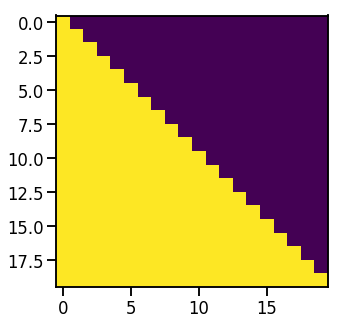

In [155]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

## Self Attention

In [0]:
def attention(Q, K, V, mask = None, dropout = None):
    d_k = Q.size(-1) # computes dimension of Q
    score = torch.matmul(Q, Ktranspose(-2, -1))/math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.mask_fill(mask==0, -1e9)
        
    out = F.softmax(scores, dim = -1)
    
    if dropout is not None:
        out = dropout(out)
        
    return torch.matmul(out, V), out 

In [0]:
class MultiHeadedAttention(nn.Module):
    """
    h: perform self attention h times, should be 8
    d_model: dimension of input into the attention layer. should be 512
    s.t. d_model/h = 64 (d_k = 64)
    project from d_model (512) to h x d_k space
    
    """
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model %h ==0
        # d_v always equal d_k
        self.d_k = d_model//h
        self.h = h
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        """
        4 linear layers, one for each of Q, K, V, and out
        """
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, Q, K, V, mask = None):
        if mask is not None:
            # apply masking to all h heads
            mask = mask.unsqueeze(1)
        
        bs = Q.size(0)
        
        # apply linear projection to split into h heads of size (h x d_k)
        Q = self.q_linear(Q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        K = self.k_linear(K).view(bs, -1, self.h, self.d_k).transpose(1,2)
        V = self.v_linear(V).view(bs, -1, self.h, self.d_k).transpose(1,2)
        
        # apply attetion
        scores = attention(Q, K, V, mask = mask, dropout = self.dropout)
        
        # concatenate and apply linear layer to project back into d_model space
        x = scores.transpose(1,2).congiguous()\
                    .view(bs, -1, self.h*self.d_k)
        return self.out(x)
        
        
        
        

In [0]:
class PositionwiseFeedForward(nn.Module):
    """
    d_model = 512
    d_ff = 2048
    
    """
    
    def __init__(self, d_model, d_ff, dropout = 0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

## Embedding


In [0]:
class Embedding(nn.Module):
    
    """
    
    Embeds input and output tokens to d_model-dimensional vector space (512)
    Multiply the embedding layer by sqrt(d_model)
    
    """
    
    def __init__(self, d_model, vocab):
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab, self.d_model)
        
    def forward(self, x):
        return self.embed(x)*math.sqrt(self.d_model)

## Positional Encoding

In [0]:
class PositionalEncoding(nn.Module):
    """
    
    Use positional encoding to tell the model the position of the token in the sequence
    Same dimension as d_model so they can be summed
    Use sin/cos functions with different frequencies
        
    """
    
    def __init__ (self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

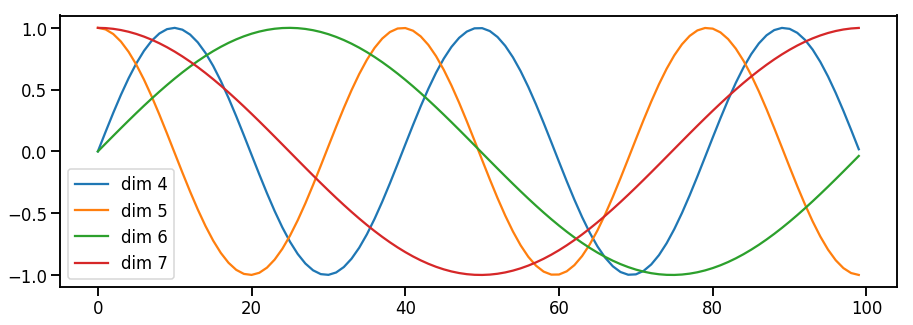

In [161]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Model

In [0]:
def make_model(src_vocab, target_vocab, N = 6, d_model = 512, d_ff=2048, h=8, dropout = 0.1):
    """
    
    Build the transformer model
    src_vocab: dimension(length) of input vocab
    N: number of copies of the self attn layer
    d_model: number of units in the self attn layer
    d_ff: number of units in the ff layer
    h: number of heads for multi-headed attn
    """
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = Encoder_Decoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N), # make 6 copies of self attn layers for encoder
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
    nn.Sequential(Embedding(d_model, src_vocab,), c(position)),
    nn.Sequential(Embedding(d_model, target_vocab), c(position)),
    Generator(d_model, target_vocab))
    
    # initialization of the weights
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model
                                

In [0]:
test_model = make_model(10, 10, 2)